<a href="https://colab.research.google.com/github/thomas-greig/MSc/blob/main/NR_AvAdd_NN_ani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

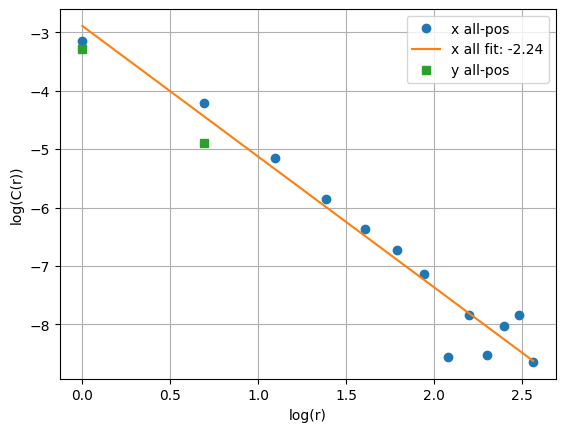

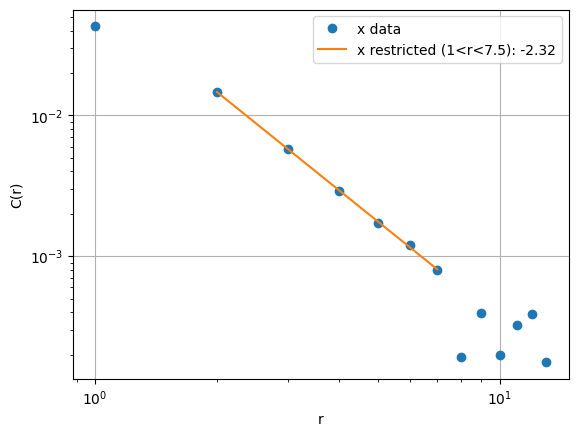

=== All-positive fits ===
X-axis (all-positive)    exponents: [-2.2372]
                         mean ± SD: -2.2372 ± 0.0000   mean R²: 0.9485
Y-axis (all-positive)    exponents: [-2.3307]
                         mean ± SD: -2.3307 ± 0.0000   mean R²: 1.0000

=== Restricted fits (1 < r < 7.5) ===
X-axis (restricted)      exponents: [-2.3159]
                         mean ± SD: -2.3159 ± 0.0000   mean R²: 0.9994
Y-axis (restricted)      exponents: [nan]
                         mean ± SD: nan ± nan   mean R²: nan


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# =========================
# Global Parameters (from your snippet)
# =========================
Lx, Ly = 40, 40
N = 800
steps = 10_000_000
b_over_T = 4.0            # β/T
J_over_T = b_over_T / 3.0 # J/T
eps = 0                   # <- as in your code
drift_direction = (1, 0)
sample_every = 2400
relaxation_index = int(0.2 * steps / sample_every)

# multi-run control
runs = 1
base_seed = 12345
DO_PLOTS = True  # show plots for the final run only

# =========================
# Helpers
# =========================
nn_disps = [(-1,0),(1,0),(0,-1),(0,1)]

def nn_sum(occ, x, y):
    s = 0
    for dx,dy in nn_disps:
        s += occ[(x+dx) % Lx, (y+dy) % Ly]
    return s

def compute_2D_move_probabilities(positions, idx, occupancy, Lx, Ly, b_over_T, J_over_T, eps, drift_direction):
    moves = [(-1, 0), (1, 0), (0, 0), (0, 1), (0, -1)]  # L, R, S, U, D
    weights = []

    def sigmoid(x): return 1.0 / (1.0 + np.exp(x))
    dx_bias, dy_bias = drift_direction
    x_old, y_old = positions[idx]

    n_old = occupancy[x_old, y_old]
    S_old = nn_sum(occupancy, x_old, y_old)

    for dx, dy in moves:
        if dx == 0 and dy == 0:
            dE = 0.0
        else:
            x_trial = (x_old + dx) % Lx
            y_trial = (y_old + dy) % Ly

            n_trial = occupancy[x_trial, y_trial]
            S_trial = nn_sum(occupancy, x_trial, y_trial)

            dE_on = 2.0 * b_over_T * (1 + n_trial - n_old)
            dE_nn = - J_over_T * (S_trial - S_old - 1)
            drive = -(dx * dx_bias + dy * dy_bias)

            dE = dE_on + dE_nn + drive

        base_prob = sigmoid(dE)
        drift_alignment = dx * dx_bias + dy * dy_bias  # 0 for stay
        weight = (1 + eps * drift_alignment) * base_prob
        weights.append(weight)

    weights = np.asarray(weights, dtype=float)
    probs = weights / np.sum(weights)
    return probs, moves

def compute_2D_correlation(data):
    from numpy.fft import fft2, ifft2, fftshift
    T, Lx_, Ly_ = data.shape
    mean_n = data.mean(axis=0)
    fluct = data - mean_n
    corr_fft = np.zeros((Lx_, Ly_), dtype=np.complex128)
    for frame in fluct:
        f = fft2(frame)
        corr_fft += f * np.conj(f)
    corr = np.real(ifft2(corr_fft)) / (T * Lx_ * Ly_)
    corr = fftshift(corr)
    return corr

# =========================
# Single simulation + fits (all-positive and restricted window 1<r<7.5)
# =========================
def simulate_and_fit(seed=None, do_plots=False):
    if seed is not None:
        np.random.seed(seed)

    # --- Initialise randomly ---
    positions = np.column_stack((
        np.random.randint(0, Lx, size=N),
        np.random.randint(0, Ly, size=N)
    ))
    occupancy = np.zeros((Lx, Ly), dtype=int)
    for x, y in positions:
        occupancy[x, y] += 1

    # --- Run Simulation ---
    n_samples = steps // sample_every + 1
    occupancy_time_series = np.zeros((n_samples, Lx, Ly), dtype=int)
    sample_index = 0

    for t in range(steps):
        idx = np.random.randint(N)
        probs, moves = compute_2D_move_probabilities(
            positions, idx, occupancy, Lx, Ly, b_over_T, J_over_T, eps, drift_direction
        )
        dx, dy = moves[np.random.choice(len(moves), p=probs)]
        x_old, y_old = positions[idx]
        x_new = (x_old + dx) % Lx
        y_new = (y_old + dy) % Ly
        positions[idx] = [x_new, y_new]
        occupancy[x_old, y_old] -= 1
        occupancy[x_new, y_new] += 1

        if t % sample_every == 0:
            occupancy_time_series[sample_index] = occupancy
            sample_index += 1

    # --- Correlation (use stationary part) ---
    stationary = occupancy_time_series[relaxation_index:]
    corr_2d = compute_2D_correlation(stationary)

    # --- Directional cuts from the center ---
    Lx_, Ly_ = corr_2d.shape
    cx, cy = Lx_ // 2, Ly_ // 2
    cut_x = corr_2d[cx:, cy]
    r_x = np.arange(0, len(cut_x))
    cut_y = corr_2d[cx, cy:]
    r_y = np.arange(0, len(cut_y))

    out = {}

    # ---------- ALL POSITIVE POINTS (log-log) ----------
    # X
    pos_x = cut_x[1:] > 0
    if np.count_nonzero(pos_x) >= 2:
        log_r_x_all = np.log(r_x[1:][pos_x])
        log_c_x_all = np.log(cut_x[1:][pos_x])
        sx_all, ix_all, r_x_all, _, _ = linregress(log_r_x_all, log_c_x_all)
        out["slope_x_all"] = sx_all
        out["r2_x_all"] = r_x_all**2
    else:
        log_r_x_all = log_c_x_all = None
        ix_all = None
        out["slope_x_all"] = np.nan
        out["r2_x_all"] = np.nan

    # Y
    pos_y = cut_y[1:] > 0
    if np.count_nonzero(pos_y) >= 2:
        log_r_y_all = np.log(r_y[1:][pos_y])
        log_c_y_all = np.log(cut_y[1:][pos_y])
        sy_all, iy_all, r_y_all, _, _ = linregress(log_r_y_all, log_c_y_all)
        out["slope_y_all"] = sy_all
        out["r2_y_all"] = r_y_all**2
    else:
        log_r_y_all = log_c_y_all = None
        iy_all = None
        out["slope_y_all"] = np.nan
        out["r2_y_all"] = np.nan

    # ---------- RESTRICTED WINDOW 1 < r < 7.5 ----------
    def window_fit(r_vals, c_vals, rmin=1.0, rmax=7.5):
        mask = (r_vals > rmin) & (r_vals < rmax) & (c_vals > 0)
        if np.count_nonzero(mask) >= 2:
            lr = np.log(r_vals[mask])
            lc = np.log(c_vals[mask])
            slope, intercept = np.polyfit(lr, lc, 1)
            # manual R^2
            ss_res = np.sum((lc - (slope*lr + intercept))**2)
            ss_tot = np.sum((lc - np.mean(lc))**2)
            r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan
            return slope, intercept, r2, r_vals[mask], c_vals[mask]
        return np.nan, None, np.nan, None, None

    # X restricted
    sx_res, ix_res, r2x_res, r_fit_x, c_fit_x = window_fit(r_x[1:], cut_x[1:])
    out["slope_x_res"] = sx_res
    out["r2_x_res"] = r2x_res

    # Y restricted
    sy_res, iy_res, r2y_res, r_fit_y, c_fit_y = window_fit(r_y[1:], cut_y[1:])
    out["slope_y_res"] = sy_res
    out["r2_y_res"] = r2y_res

    # ---------- Plots for final run ----------
    if do_plots:
        # All-positive log–log (in log space)
        plt.figure()
        if log_r_x_all is not None and log_c_x_all is not None and np.isfinite(out["slope_x_all"]):
            plt.plot(log_r_x_all, log_c_x_all, 'o', label="x all-pos")
            plt.plot(log_r_x_all, out["slope_x_all"]*log_r_x_all + ix_all, '-',
                     label=f"x all fit: {out['slope_x_all']:.2f}")
        if log_r_y_all is not None and log_c_y_all is not None and np.isfinite(out["slope_y_all"]):
            plt.plot(log_r_y_all, log_c_y_all, 's', label="y all-pos")
            # plt.plot(log_r_y_all, out["slope_y_all"]*log_r_y_all + iy_all, '-',
            #          label=f"y all fit: {out['slope_y_all']:.2f}") # Removed Y-axis fit plot
        plt.xlabel("log(r)"); plt.ylabel("log(C(r))")
        # plt.title("All-positive log–log fits") # Removed title
        plt.grid(True); plt.legend(); plt.show()

        # Restricted window plots on log–log axes
        if r_fit_x is not None and c_fit_x is not None and np.isfinite(sx_res):
            plt.figure()
            plt.grid(True)
            rx_full = r_x[1:][cut_x[1:] > 0]
            cx_full = cut_x[1:][cut_x[1:] > 0]
            plt.loglog(rx_full, cx_full, 'o', label="x data")
            r_line = np.linspace(np.min(r_fit_x), np.max(r_fit_x), 200)
            C_line = np.exp(ix_res) * r_line**sx_res
            plt.loglog(r_line, C_line, '-', label=f"x restricted (1<r<7.5): {sx_res:.2f}")
            plt.xlabel("r"); plt.ylabel("C(r)");
            # plt.title("Restricted fit (X)") # Removed title
            plt.legend(); plt.show()

        if r_fit_y is not None and c_fit_y is not None and np.isfinite(sy_res):
            plt.figure()
            plt.grid(True)
            ry_full = r_y[1:][cut_y[1:] > 0]
            cy_full = cut_y[1:][cut_y[1:] > 0]
            plt.loglog(ry_full, cy_full, 's', label="y data")
            r_line = np.linspace(np.min(r_fit_y), np.max(r_fit_y), 200)
            C_line = np.exp(iy_res) * r_line**sy_res
            plt.loglog(r_line, C_line, '-', label=f"y restricted (1<r<7.5): {sy_res:.2f}")
            plt.xlabel("r"); plt.ylabel("C(r)");
            # plt.title("Restricted fit (Y)") # Removed title
            plt.legend(); plt.show()

    return out

# =========================
# Run 5 times and aggregate
# =========================
all_results = []
for i in range(runs):
    res = simulate_and_fit(seed=base_seed + i, do_plots=DO_PLOTS and (i == runs - 1))
    all_results.append(res)

# =========================
# Collate arrays
# =========================
ex_x_all = np.array([r["slope_x_all"] for r in all_results], float)
ex_y_all = np.array([r["slope_y_all"] for r in all_results], float)
r2_x_all = np.array([r["r2_x_all"] for r in all_results], float)
r2_y_all = np.array([r["r2_y_all"] for r in all_results], float)

ex_x_res = np.array([r["slope_x_res"] for r in all_results], float)
ex_y_res = np.array([r["slope_y_res"] for r in all_results], float)
r2_x_res = np.array([r["r2_x_res"] for r in all_results], float)
r2_y_res = np.array([r["r2_y_res"] for r in all_results], float)

# =========================
# Stats + Reporting
# =========================
np.set_printoptions(precision=4, suppress=True)

def finite_stats(arr):
    a = arr[np.isfinite(arr)]
    if a.size == 0:
        return np.nan, np.nan
    mean = np.mean(a)
    sd = np.std(a, ddof=1) if a.size > 1 else 0.0
    return mean, sd

def report(label, vals, r2s):
    mean, sd = finite_stats(vals)
    mean_r2, _ = finite_stats(r2s)
    print(f"{label:24s} exponents: {vals}")
    print(f"{'':24s} mean ± SD: {mean:.4f} ± {sd:.4f}   mean R²: {mean_r2:.4f}")

print("=== All-positive fits ===")
report("X-axis (all-positive)", ex_x_all, r2_x_all)
report("Y-axis (all-positive)", ex_y_all, r2_y_all)

print("\n=== Restricted fits (1 < r < 7.5) ===")
report("X-axis (restricted)", ex_x_res, r2_x_res)
report("Y-axis (restricted)", ex_y_res, r2_y_res)